# Library Installation

In [4]:
# Import Top2Vec library
!pip install top2vec[sentence_encoders]
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.0 MB/s eta 0:00:00


In [36]:
# Import other useful python libraries
import numpy as np
import pandas as pd
import random
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from top2vec import Top2Vec

In [3]:
from huggingface_hub import notebook_login
notebook_login()

# Data Pre-processing

In [52]:
from datasets import load_dataset
wiki_ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split = "train")

In [77]:
filtered = wiki_ds.filter(lambda d: len(d["text"]) > 1 and not d["text"].startswith(" ="))
wiki_filtered = filtered["text"][:10000]

# Top2Vec Model Training

In [78]:
t2v_model = Top2Vec(documents=wiki_filtered,
                  embedding_model='universal-sentence-encoder',
                  speed="deep-learn",
                  workers=10)

2025-03-07 07:33:43,130 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-03-07 07:33:45,227 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2025-03-07 07:33:51,102 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-03-07 07:33:56,366 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-03-07 07:34:10,007 - top2vec - INFO - Finding de

## Useful Information Extracted

In [79]:
# Get the number of topics obtained from Top2Vec
num_of_topics = t2v_model.get_num_topics()
num_of_topics

143

In [80]:
# For each topic, get the top 50 words associate with the topic
# The 50 topic words are sorted by the order of semantic similarity to the topic, from high to low
topic_words, word_scores, topic_index = t2v_model.get_topics(num_of_topics)
topic_words, word_scores, topic_index

(array([['rihanna', 'furtado', 'vocals', ..., 'yankovic', 'filmed',
         'wrote'],
        ['sholay', 'actress', 'film', ..., 'soundtrack', 'franchise',
         'watched'],
        ['building', 'buildings', 'cathedral', ..., 'roman', 'facilities',
         'forms'],
        ...,
        ['federer', 'djokovic', 'wimbledon', ..., 'safety', 'concluded',
         'abu'],
        ['irish', 'ireland', 'nesbitt', ..., 'minister', 'forces', 'tied'],
        ['plum', 'cake', 'fruit', ..., 'french', 'cathedral', 'coins']],
       dtype='<U14'),
 array([[0.33470774, 0.30205253, 0.30165172, ..., 0.17422223, 0.17301843,
         0.17300427],
        [0.43322647, 0.32298142, 0.31404   , ..., 0.17639343, 0.17564972,
         0.17558078],
        [0.2922634 , 0.2822259 , 0.2799003 , ..., 0.14881429, 0.14819083,
         0.14771423],
        ...,
        [0.3524784 , 0.34844184, 0.2920405 , ..., 0.1608895 , 0.1606483 ,
         0.16042574],
        [0.2865994 , 0.25725284, 0.25257215, ..., 0.15216

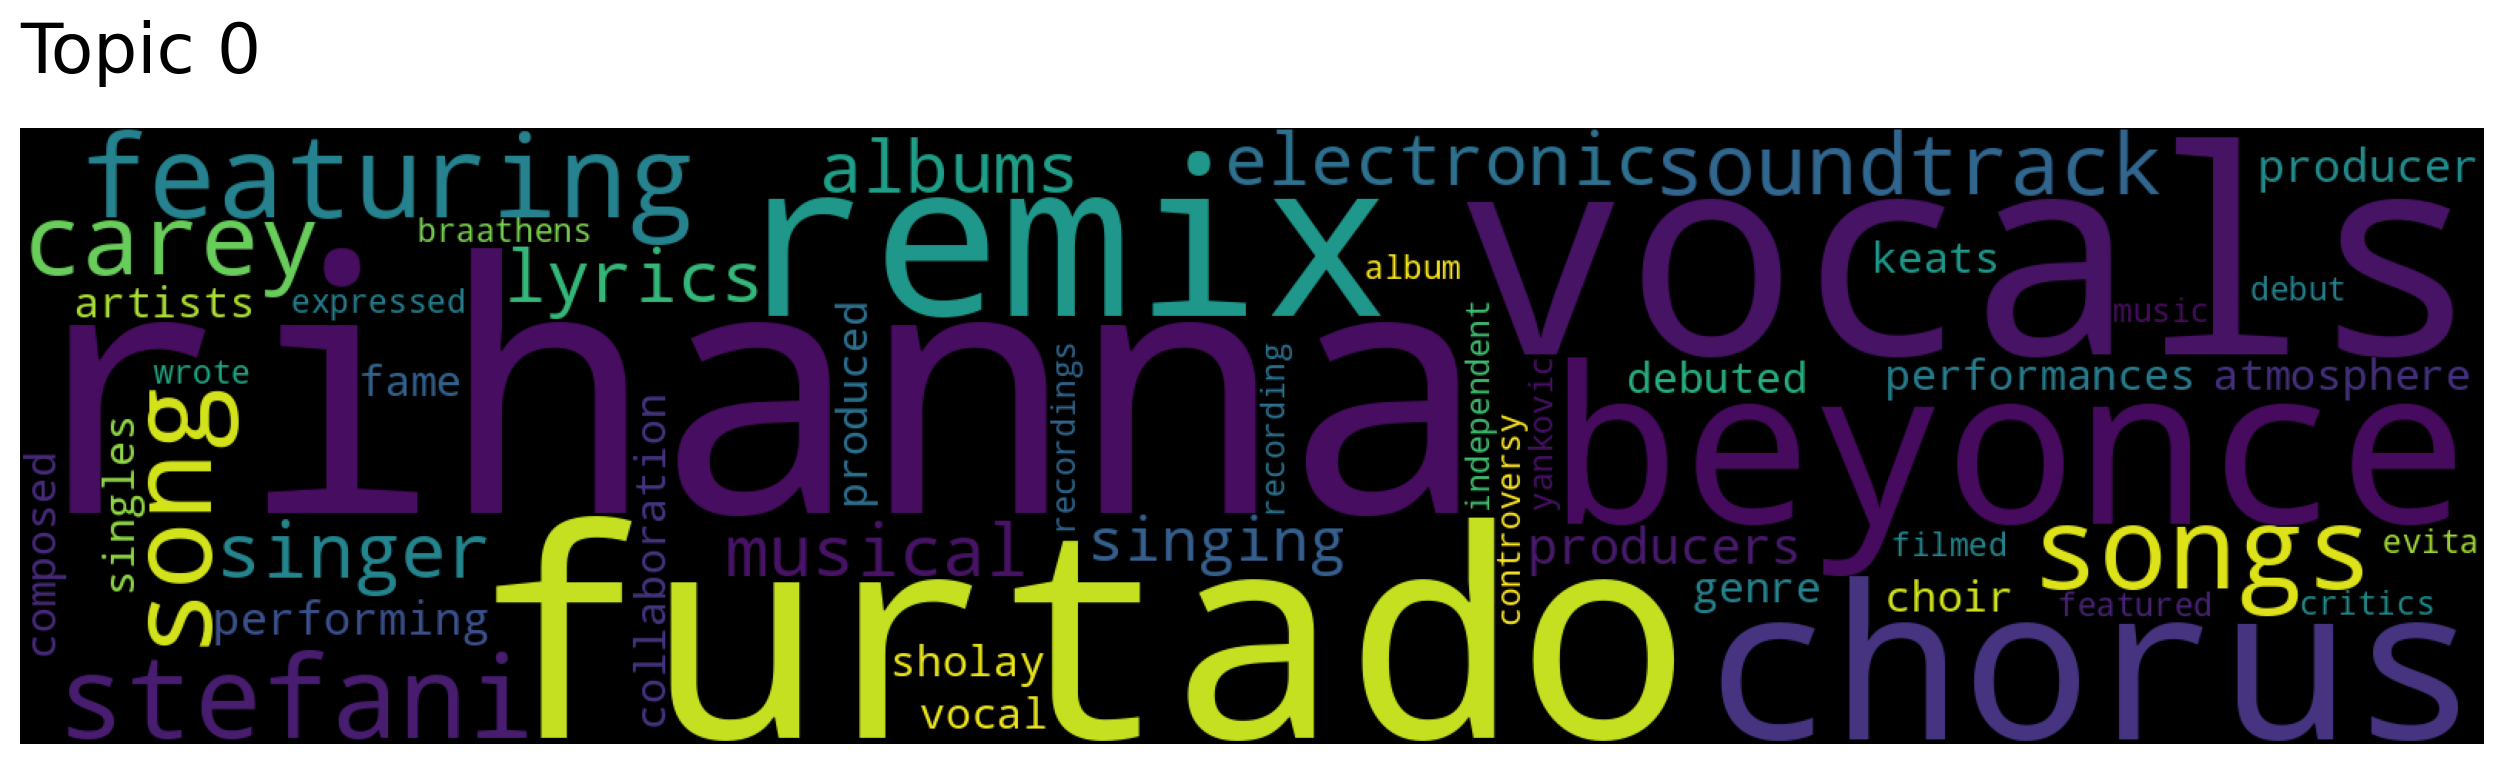

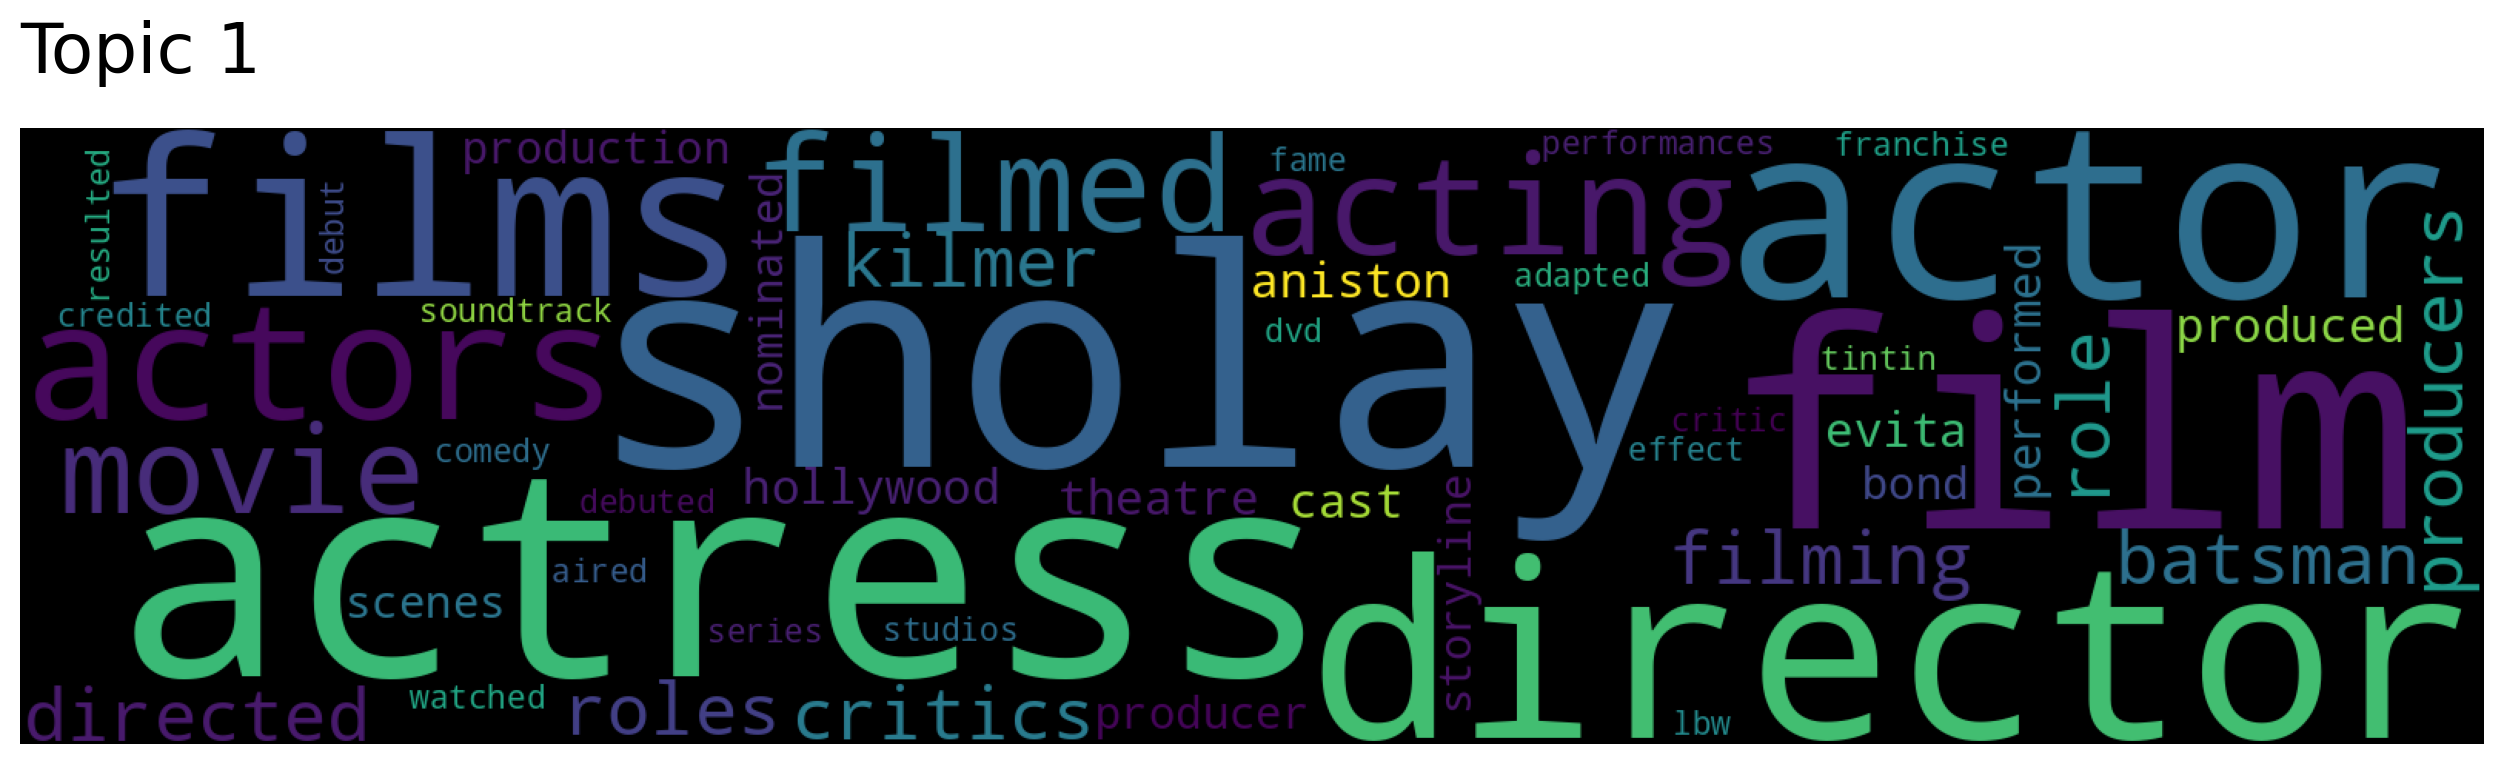

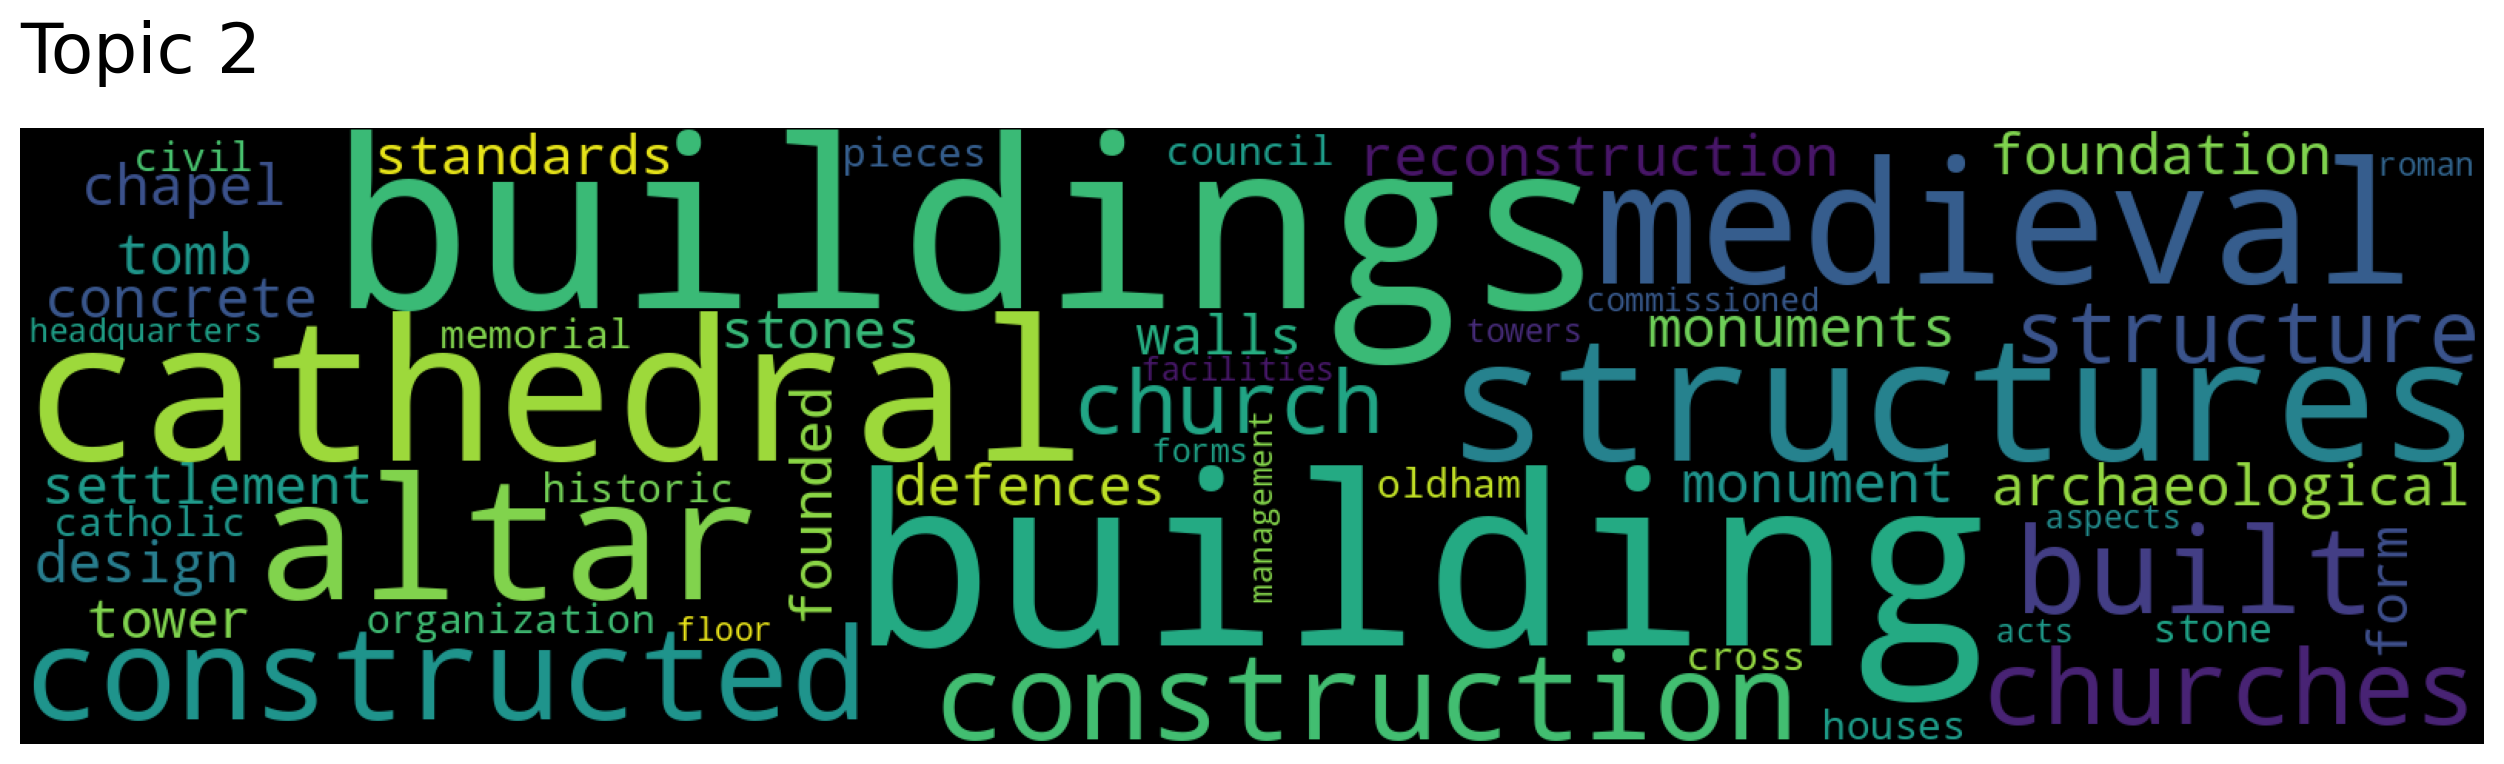

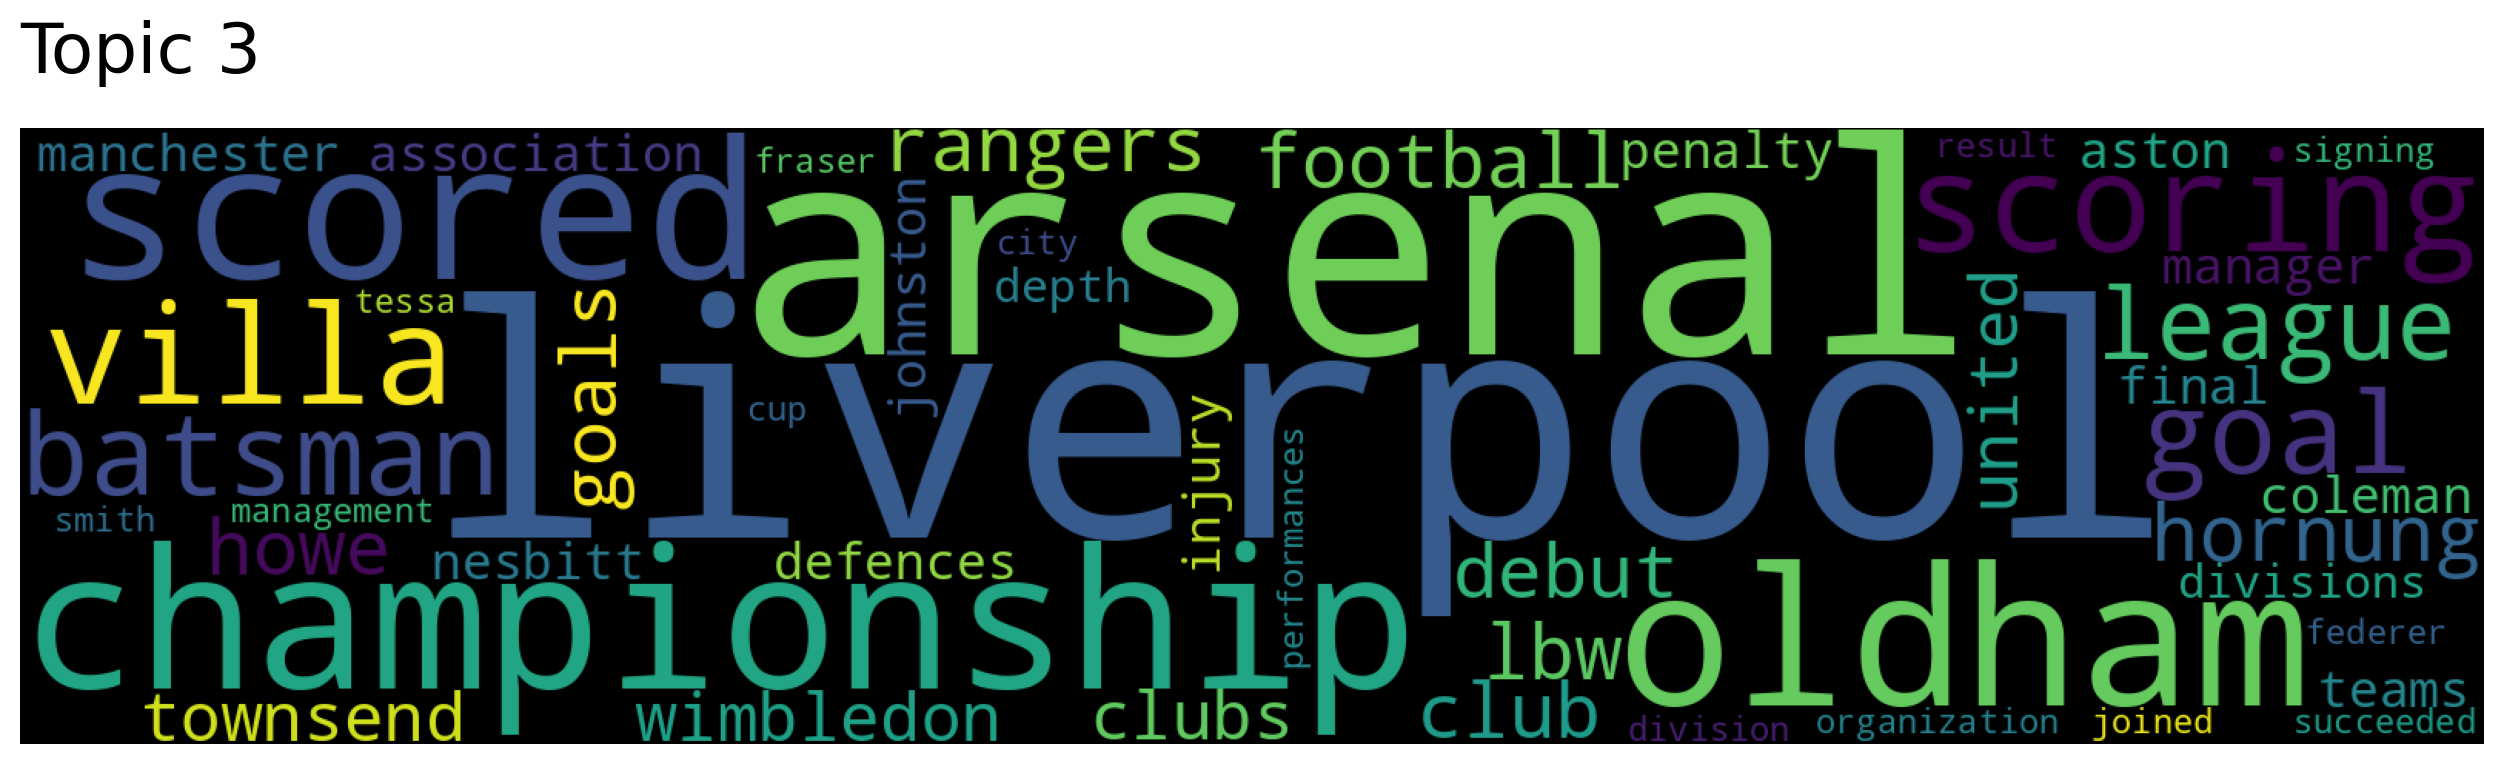

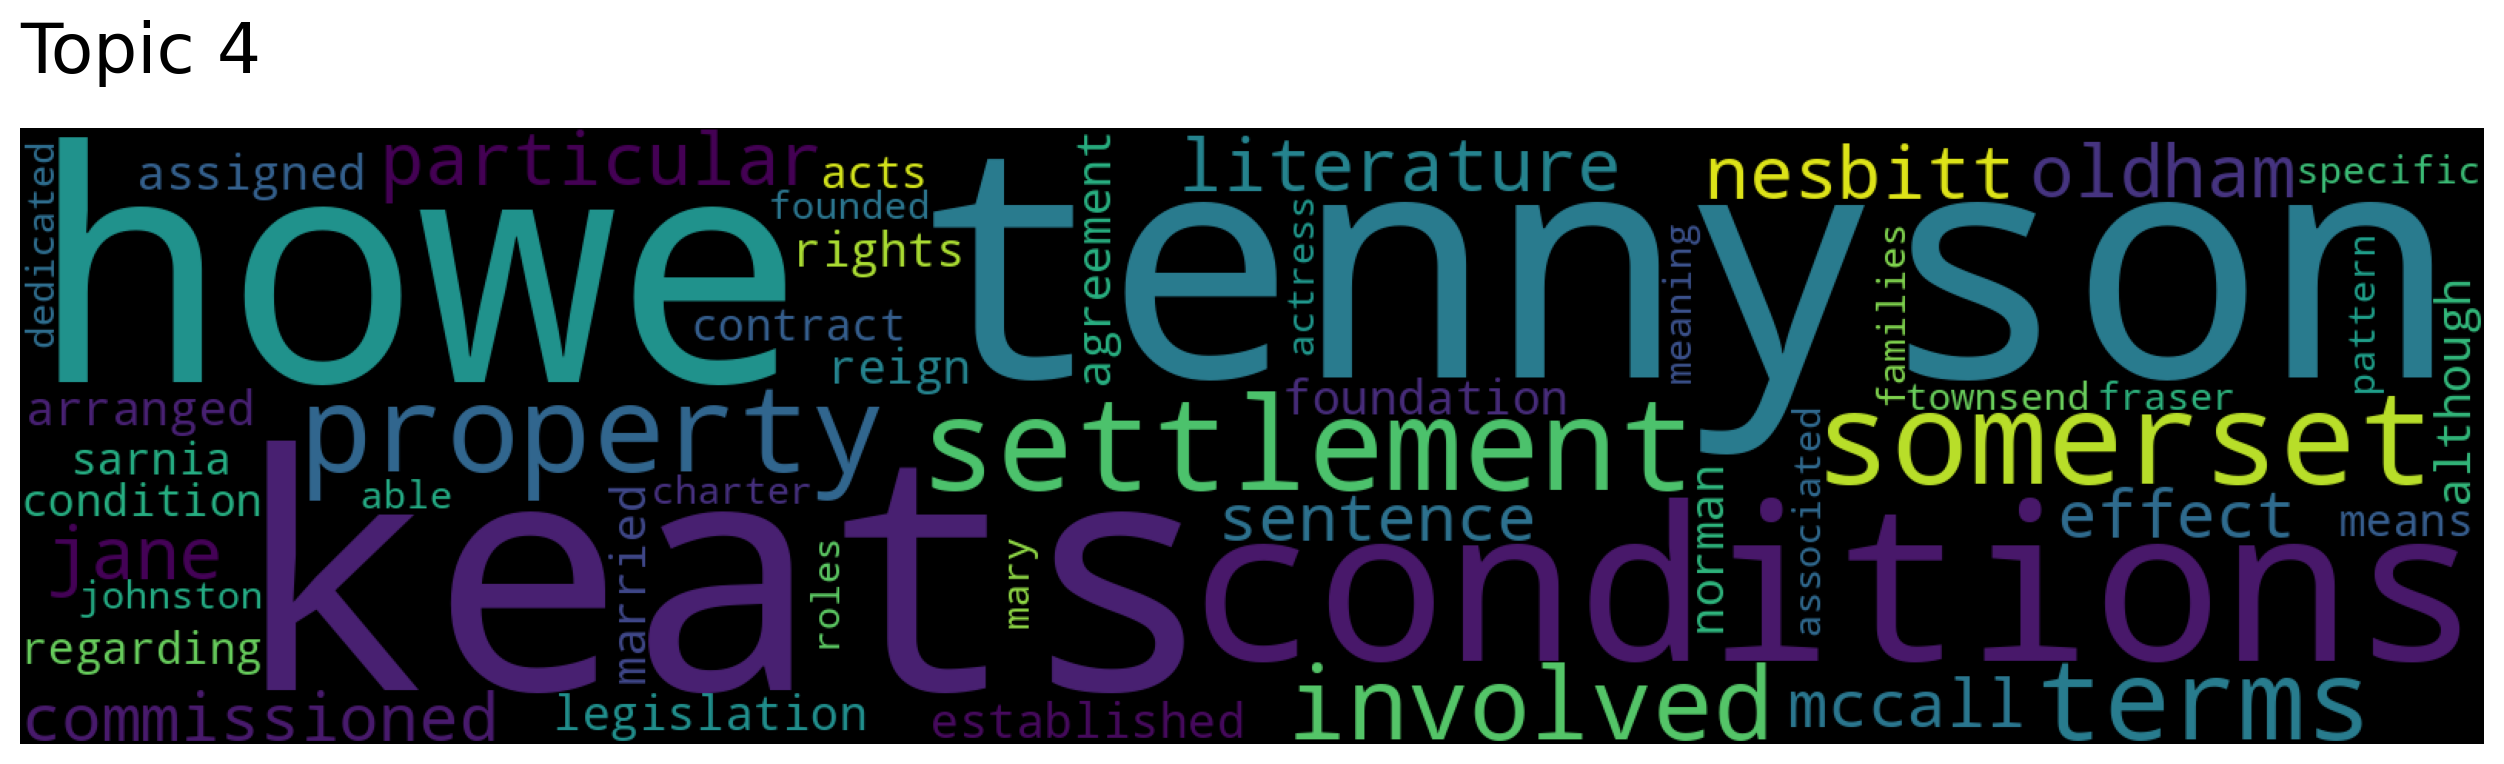

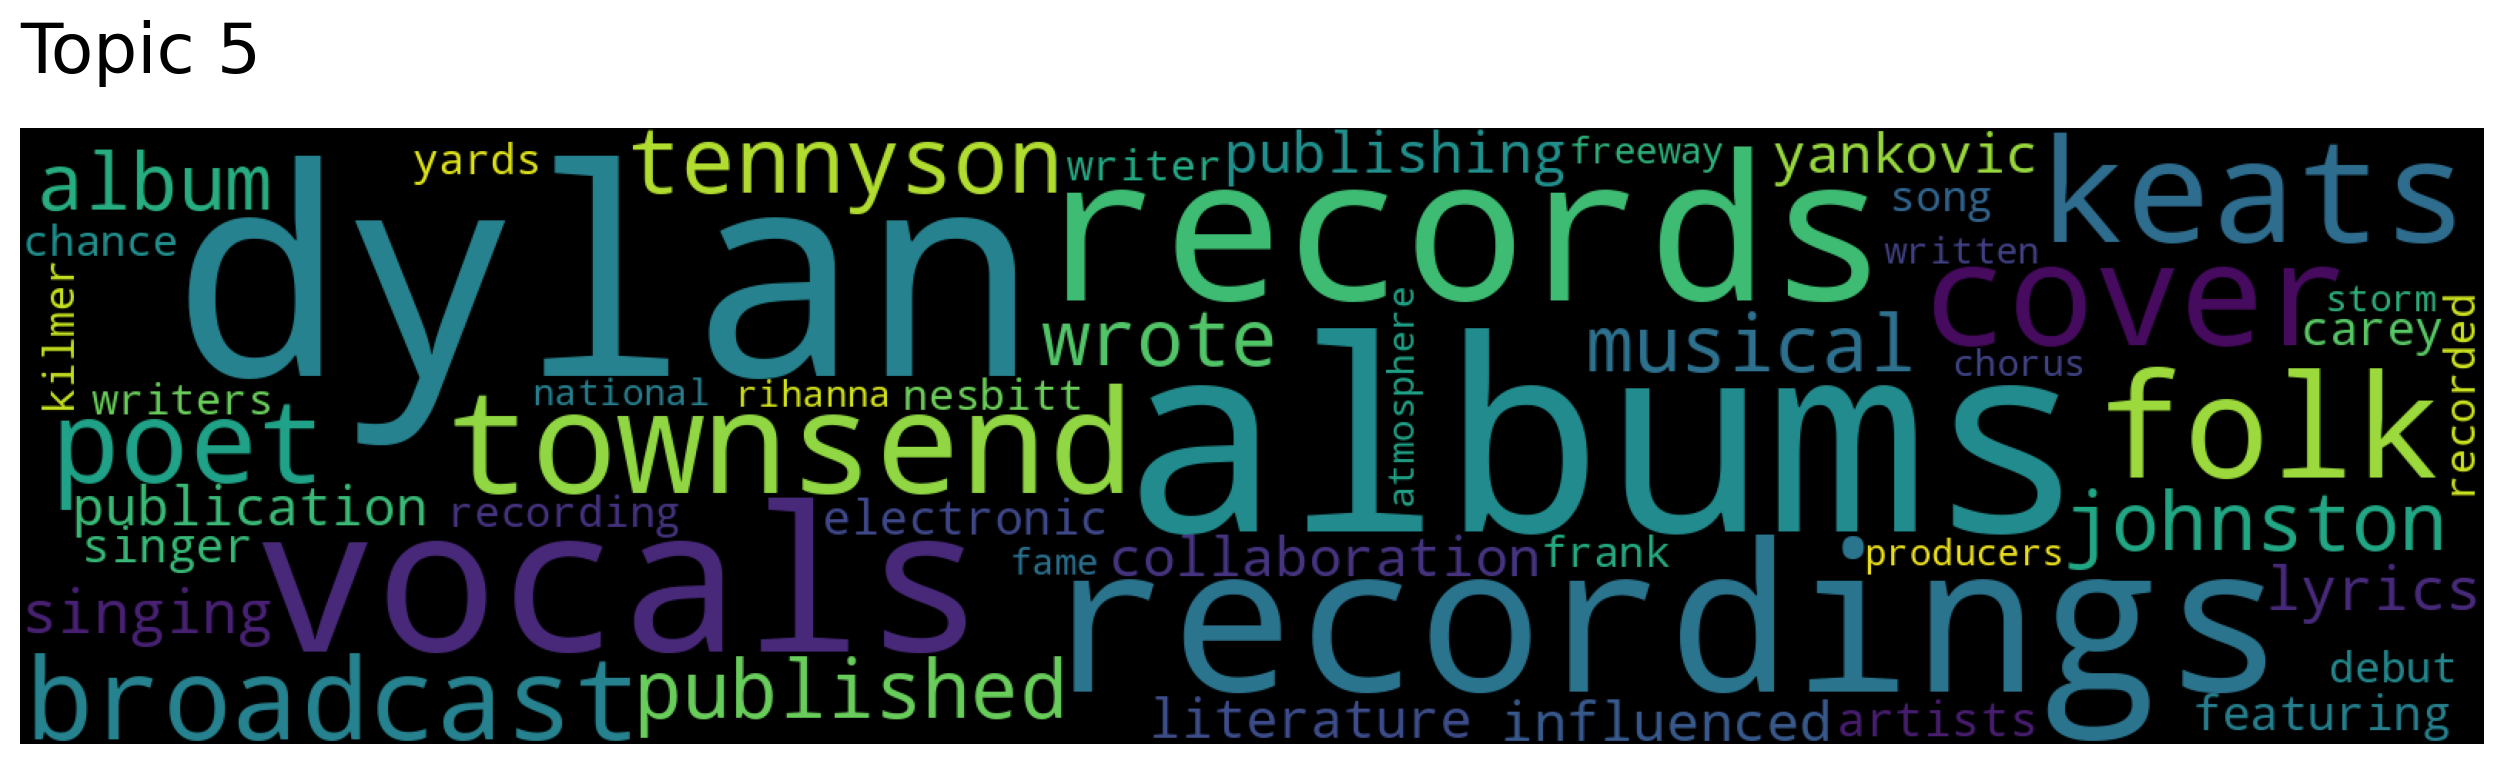

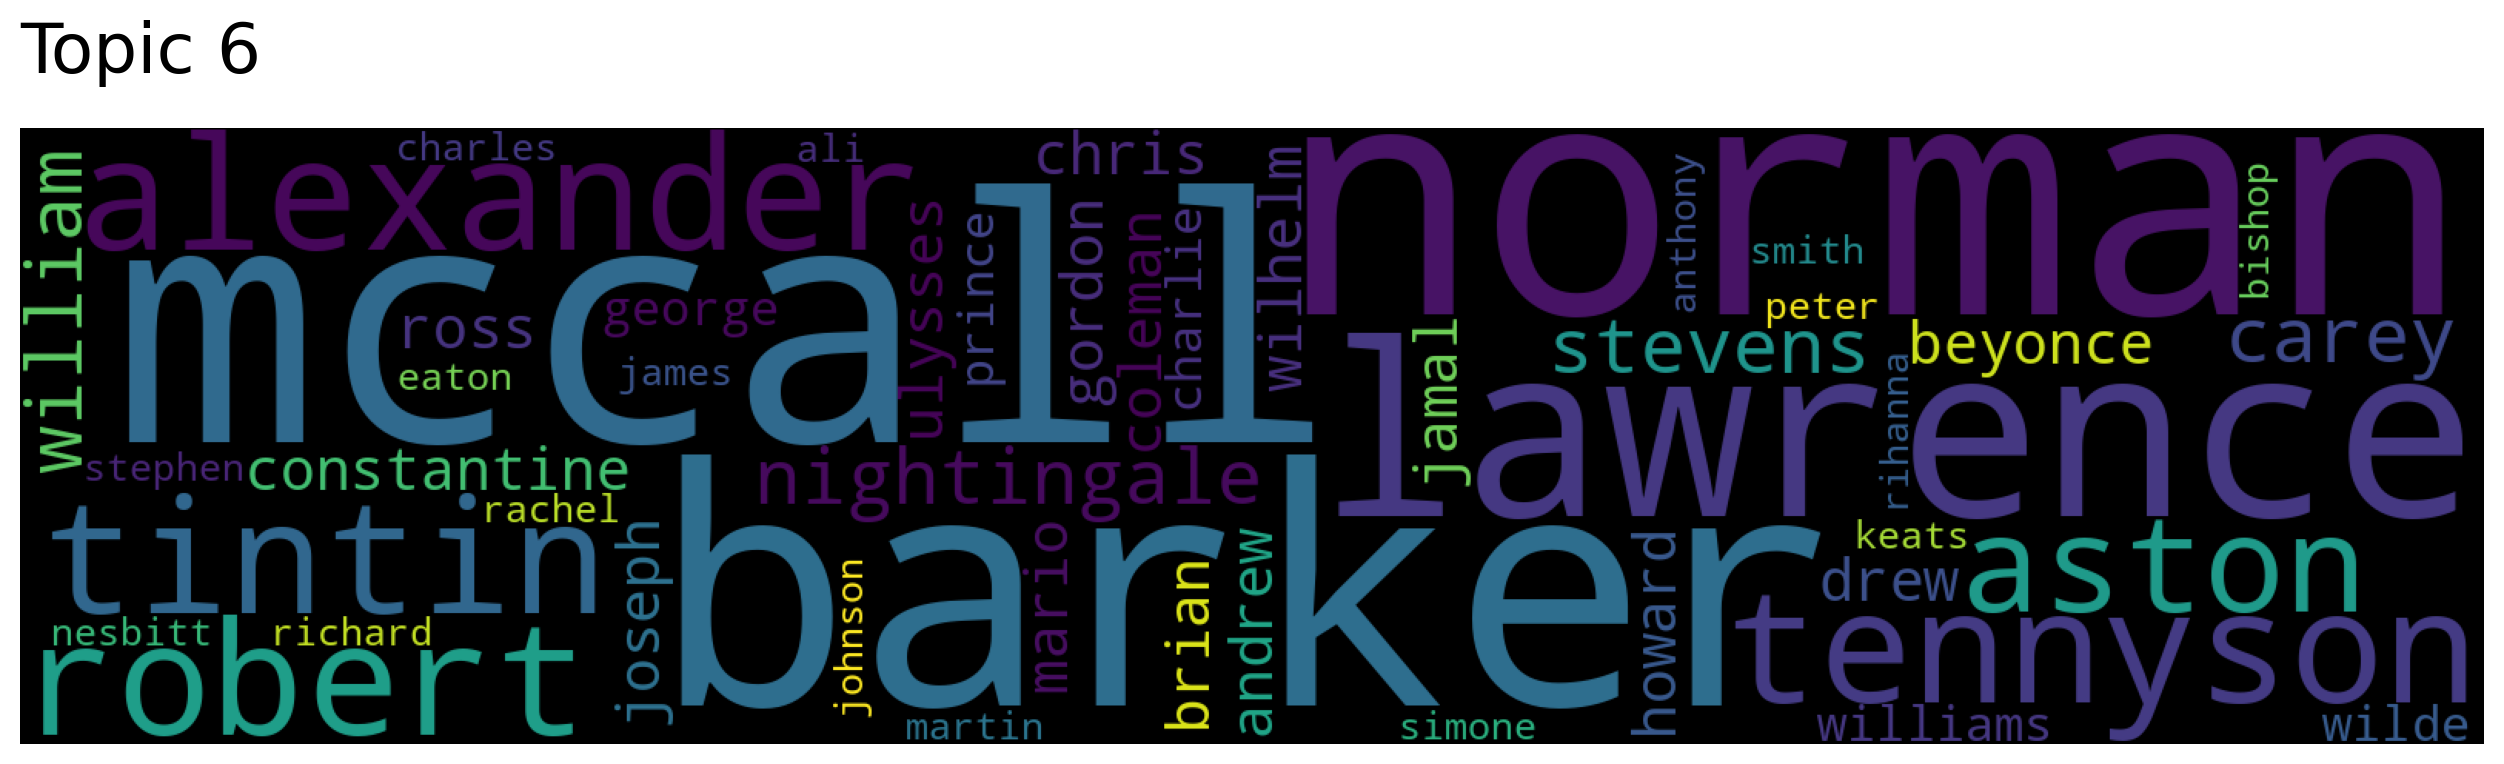

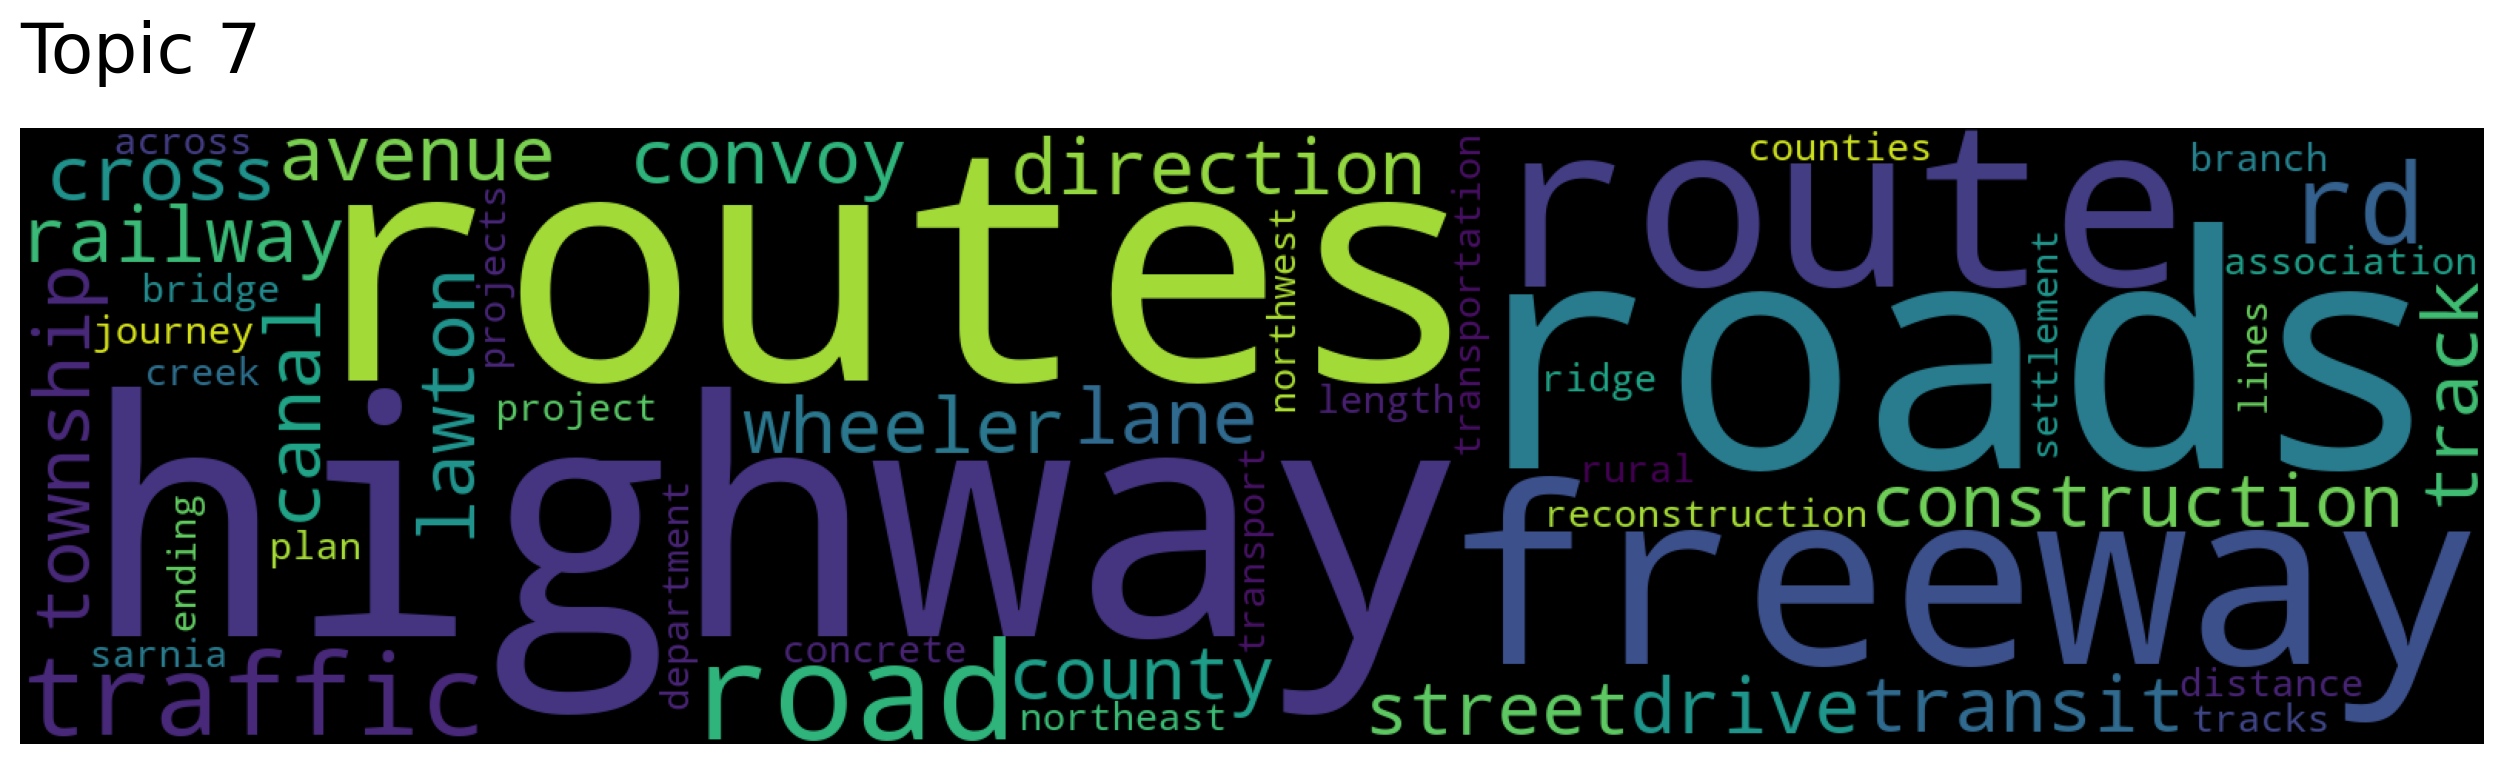

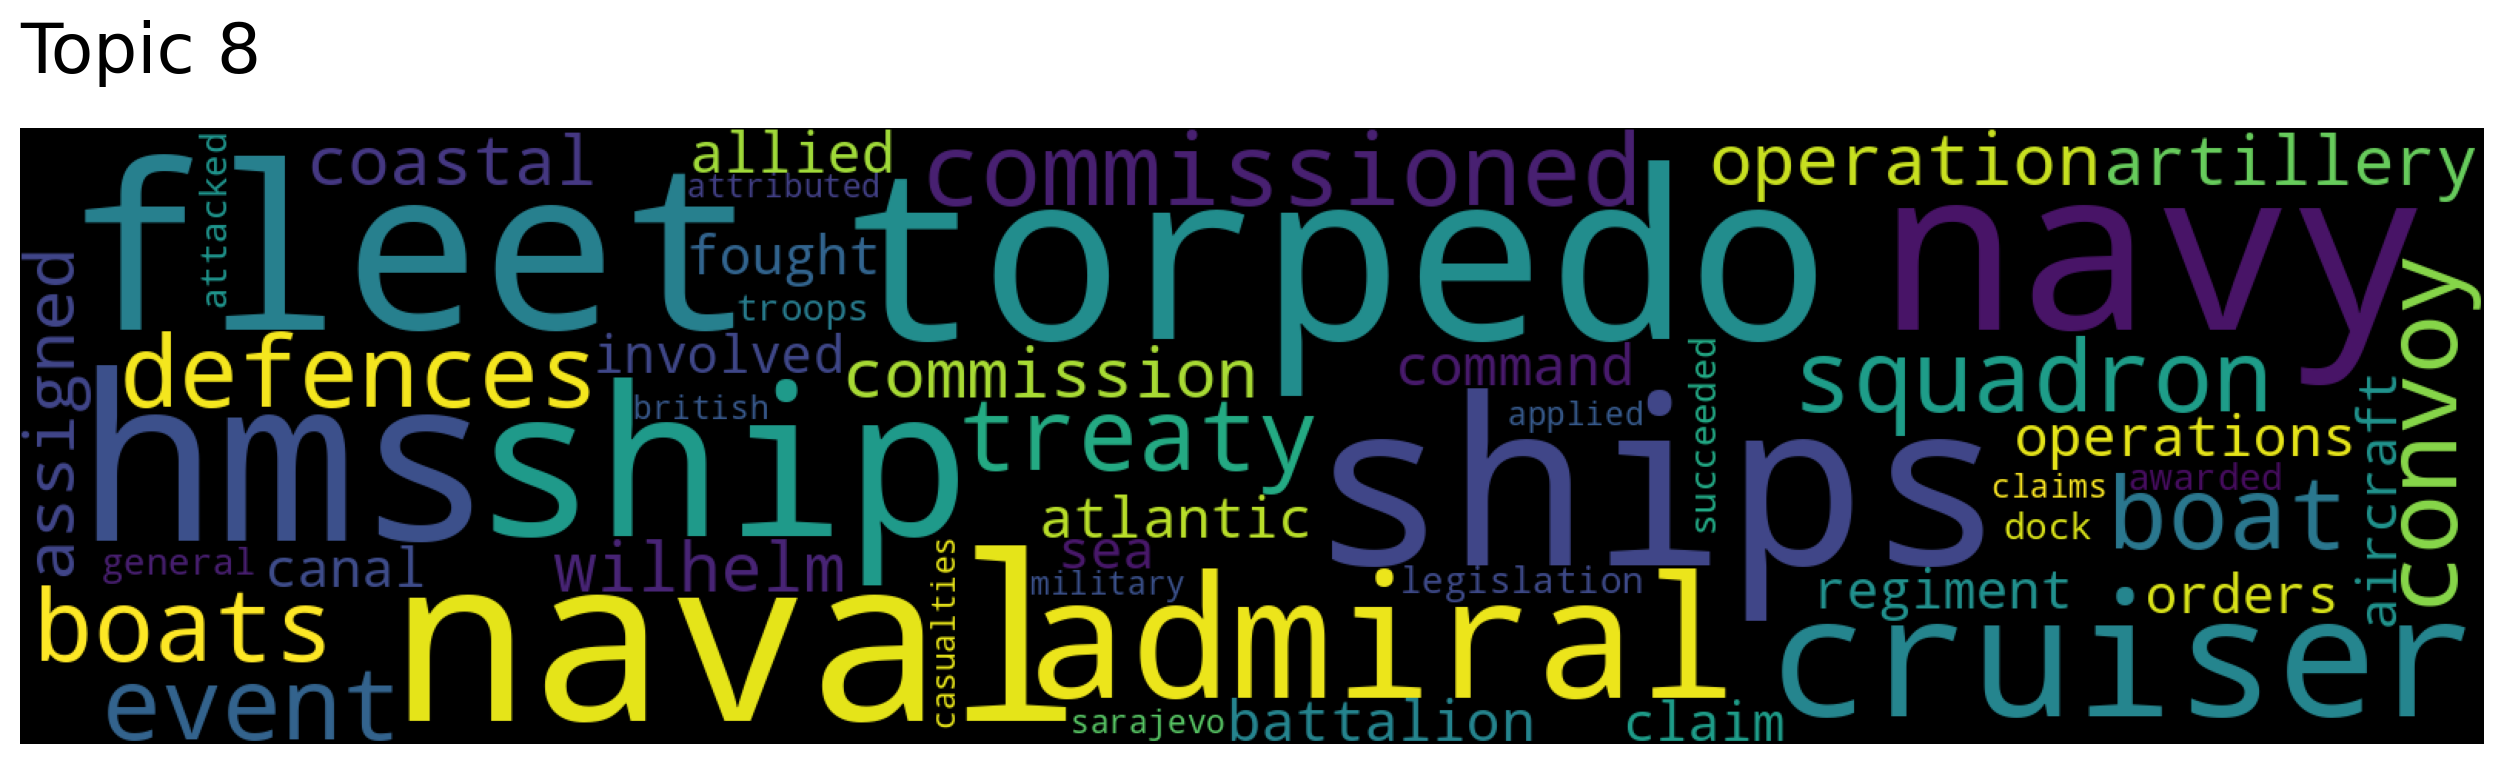

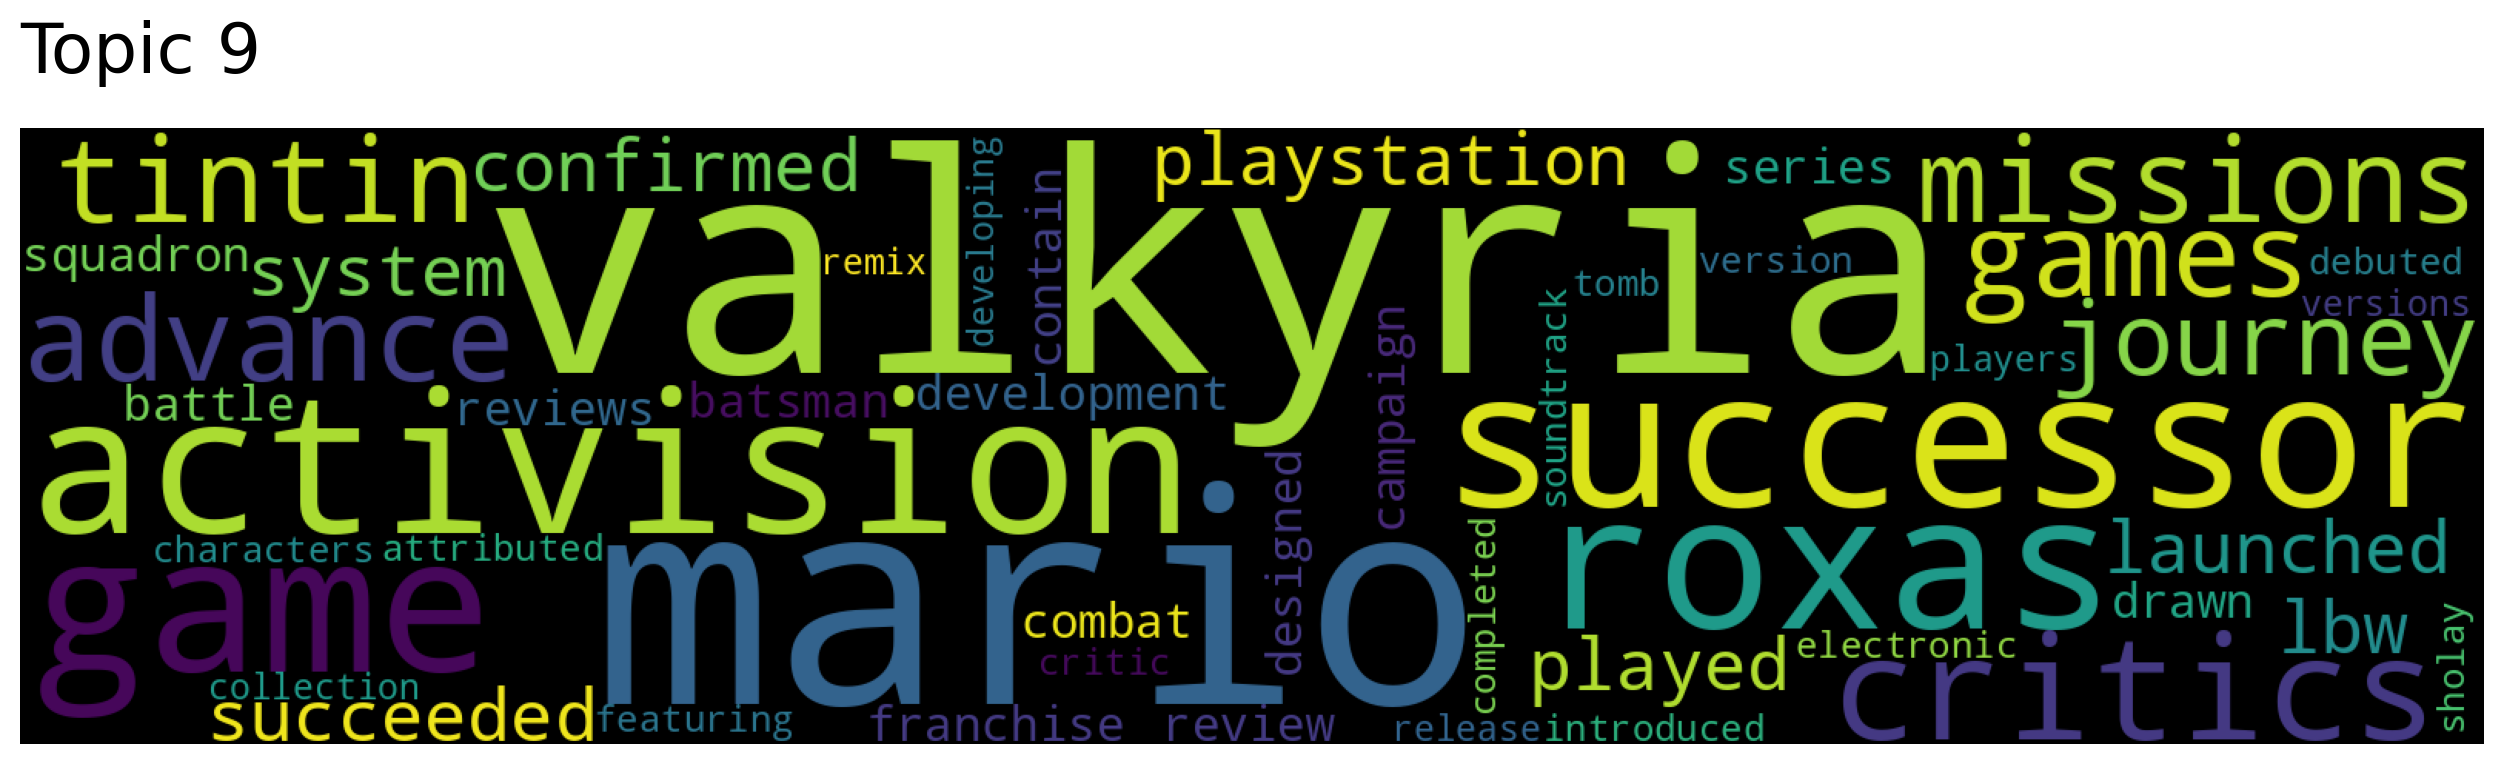

In [81]:
# View the result of some topics
for topic in topic_index[0:10]:
    t2v_model.generate_topic_wordcloud(topic, background_color="black")

In [82]:
# Search by keyword
documents, document_scores, document_nums = t2v_model.search_documents_by_keywords(keywords=["building"], num_docs=4)
for documents, document_scores, document_nums in zip(documents, document_scores, document_nums):
    print(f"Document: {document_nums}, Score: {document_scores}")
    print("-----------")
    print(documents)
    print("-----------")
    print()

Document: 5419, Score: 0.3561122933575287
-----------
 The west front has two 13th century buttressed towers 27 @.@ 4 metres ( 90 ft ) high that were originally topped with wooden spires covered in protective lead . Although the difference between the construction of the base course and the transepts suggests that the towers were not part of the initial design , it is likely that the building process was not so far advanced that the masons could fully integrate the nave and towers into each other ( Fig . 7 ) . 

-----------

Document: 7195, Score: 0.3543686458339391
-----------
 Major restoration and foundation work began in the 1990s to stabilize the building . Engineers excavated under the cathedral between 1993 and 1998 . They dug shafts under the cathedral and placed shafts of concrete into the soft ground to give the edifice a more solid base to rest on . These efforts have not stopped the sinking of the complex , but they have corrected the tilting towers and ensured that the cat

# Coherence Score (CV Score) Comparsion

## Function Definition

### Top2Vec

In [83]:
# T2V CV Score Function
def t2v_Cv(model, df_columnm):
  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  top_num = model.get_num_topics()
  topics, _, _ = model.get_topics(top_num)
  for topic in topics:
      top_words.append(topic)

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

### LDA

In [84]:
# Library For LDA
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
n_features = 10
n_components = 10
top_n_words = 20

In [86]:
# LDA Model Training
tf_vectorizer = CountVectorizer(
  max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(wiki_filtered)

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0
)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5)

In [87]:
# LDA CV Score Function
def lda_Cv(model, df_columnm):
  topics = model.components_

  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      # print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return top_words, coherence

## Comparsion

In [89]:
# Get CV Score
t2v_coherence = t2v_Cv(t2v_model, wiki_filtered)
lda_top_words, lda_coherence = lda_Cv(lda, wiki_filtered)
# Print the result
print(f"T2V: {t2v_coherence}, LDA: {lda_coherence}")
if t2v_coherence > lda_coherence:
  print("Our experiment result shows that the performance of Top2Vec alligns with the author claims")

T2V: 0.4612237690542582, LDA: 0.4255813979832361
Our experiment result shows that the performance of Top2Vec alligns with the author claims
